In [6]:
# Standard library imports
import os

# Contributed library imports
import geopandas as gpd
import numpy as np
from pathlib import Path

# Our imports
from multiview_mapping_toolkit.meshes import TexturedPhotogrammetryMesh
from multiview_mapping_toolkit.utils.prediction_metrics import compute_and_show_cf
from multiview_mapping_toolkit.utils.geospatial import get_overlap_vector

sys.path.append("../..")
from constants import get_IDs_to_labels

# Set constants
You should be able to define most of the behavior from these constants

In [7]:
prediction_site_name = "delta"

In [8]:
## Parameters to control the outputs
# Repeat the labeling process
RETEXTURE = False
# Points less than this height (meters) above the DTM are considered ground
HEIGHT_ABOVE_GROUND_THRESH = 2
# The image is downsampled to this fraction for accelerated rendering
RENDER_IMAGE_SCALE = 0.25
# Cameras within this distance of the traing data are used in the rendering process
BUFFER_RADIUS_METERS = 50
# Downsample target
DOWNSAMPLE_TARGET = 1
# Image downsample factor for aggregation
AGGREGATE_IMAGE_SCALE = 0.25

## Python interpreter and script locations
MMSEG_UTILS_PYTHON = "/ofo-share/repos-david/conda/envs/mmseg-utils/bin/python"
MMSEG_PYTHON = "/ofo-share/repos-david/conda/envs/openmmlab/bin/python"

FOLDER_TO_CITYSCAPES_SCRIPT = "/ofo-share/repos-david/mmsegmentation_utils/dev/dataset_creation/folder_to_cityscapes.py"
VIS_PREDS_SCRIPT = "/ofo-share/repos-david/mmsegmentation_utils/dev/visualization/visualize_semantic_labels.py"
TRAIN_SCRIPT = "/ofo-share/repos-david/mmsegmentation/tools/train.py"
INFERENCE_SCRIPT = "/ofo-share/repos-david/mmsegmentation/tools/inference.py"

# One folder up from scripts
PROJECT_ROOT = Path(os.path.abspath(""), "..", "..", "..").resolve()
SCRATCH_ROOT = Path(Path.home(), "scratch", "organized_str_disp_MVMT_experiments")

IDs_TO_LABELS = get_IDs_to_labels()
## Define the inputs
# The input labels
LABELS_FILENAME = Path(PROJECT_ROOT, "field_ref", "crowns_drone_w_field_data.geojson")
LABELS_COLUMN = "species_observed"

# The digital elevation map exported by Metashape
DTM_FILE = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "02_photogrammetry",
    "exports",
    "dtms",
    f"{prediction_site_name}.tif",
)
IMAGES_NEAR_LABELS_FOLDER = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "03_training_data",
    "images_near_labels",
)
prediction_site_long_name = {"valley": "ValleyA", "chips": "ChipsB", "delta": "DeltaB"}[
    prediction_site_name
]
IMAGE_FOLDER = f"/ofo-share/str-disp_drone-data-partial/str-disp_drone-data_imagery-missions/{prediction_site_long_name}"
PREDICTED_VECTOR_LABELS_FILE = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "05_processed_predictions",
    f"{prediction_site_name}_80m_chips_model.geojson",
)
NUMPY_EXPORT_FACES_TEXTURE_FILE = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "05_processed_predictions",
    f"{prediction_site_name}_80m_chips_model.npy",
)
NUMPY_EXPORT_CONFUSION_MATRIX_FILE = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "05_processed_predictions",
    f"{prediction_site_name}_MVMT_confusion_matrix.npy",
)

In [9]:
MESH_FILENAME_BASE = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "02_photogrammetry",
    "exports",
    "meshes",
)

CHIPS_MESH_FILENAME = Path(
    MESH_FILENAME_BASE,
    "ChipsB-120m_20230309T0502_w-mesh_w-80m_20231114T2219.ply",
)
# The mesh exported from Metashape
DELTA_MESH_FILENAME = Path(
    MESH_FILENAME_BASE,
    "DeltaB-120m_20230310T1701_w-mesh_w-80m_20231117T1746.ply",
)
# The mesh exported from Metashape
VALLEY_MESH_FILENAME = Path(
    MESH_FILENAME_BASE,
    "ValleyA-120m_20230323T0515_w-mesh.ply",
)
# The camera file exported from Metashape
CAMERAS_FILENAME_BASE = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "02_photogrammetry",
    "exports",
    "cameras",
)
CHIPS_CAMERAS_FILENAME = Path(
    CAMERAS_FILENAME_BASE,
    "ChipsB-120m_20230309T0502_w-mesh_w-80m_20231114T2219_abs_paths.xml",
)
# The camera file exported from Metashape
DELTA_CAMERAS_FILENAME = Path(
    CAMERAS_FILENAME_BASE,
    "DeltaB-120m_20230310T1701_w-mesh_w-80m_20231117T1746_abs_paths.xml",
)
# The camera file exported from Metashape
VALLEY_CAMERAS_FILENAME = Path(
    CAMERAS_FILENAME_BASE,
    "ValleyA-120m_20230323T0515_w-mesh.xml",
)

MESH_FILENAME_DICT = {
    "chips": CHIPS_MESH_FILENAME,
    "delta": DELTA_MESH_FILENAME,
    "valley": VALLEY_MESH_FILENAME,
}
CAMERAS_FILENAME_DICT = {
    "chips": CHIPS_CAMERAS_FILENAME,
    "delta": DELTA_CAMERAS_FILENAME,
    "valley": VALLEY_CAMERAS_FILENAME,
}

MESH_FILENAME = MESH_FILENAME_DICT[prediction_site_name]
CAMERAS_FILENAME = CAMERAS_FILENAME_DICT[prediction_site_name]

/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

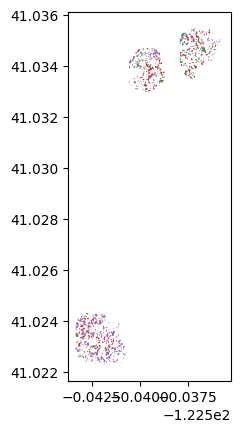

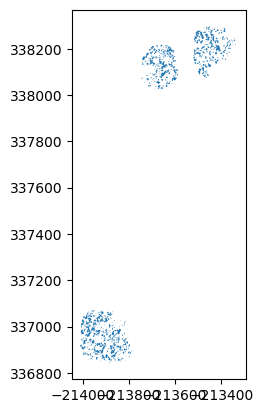

In [10]:
df = gpd.read_file(PREDICTED_VECTOR_LABELS_FILE)
df.plot("class_ID", cmap="tab10", vmin=-0.5, vmax=9.5)

class_fractions, IDs_in_original, unique_class_names = get_overlap_vector(
    unlabeled_df=LABELS_FILENAME,
    classes_df=PREDICTED_VECTOR_LABELS_FILE,
    class_column="class_ID",
)

[[ 6.46238763  0.          0.94071728 ... 10.6331194   0.
   0.        ]
 [ 8.22925803  0.         37.75249555 ...  5.04547727  0.
   0.        ]
 [ 2.24632627  0.         54.92083607 ... 15.72303823  0.
   0.        ]
 ...
 [ 2.59278391  0.          0.         ...  0.          0.
   0.        ]
 [ 0.4368482   0.          2.01859251 ...  0.          0.
   0.        ]
 [ 1.04011915  0.          0.         ...  0.          0.
   0.        ]]
[253 254 255 256 257 258 259 260 261 263 264 265 266 267 268 269 270 271
 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289
 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307
 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325
 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343
 344 345 346 347 348 349 350 351 352 354 355 356 357 358 359 360 361 363
 364 365 366 368 369 370 371 372 373 375 376 377 378 379 380 381 382 383
 384 385 386 387 388 389 390 391 392 393 394 

/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Predicted


<Axes: >

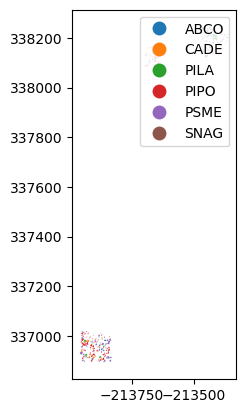

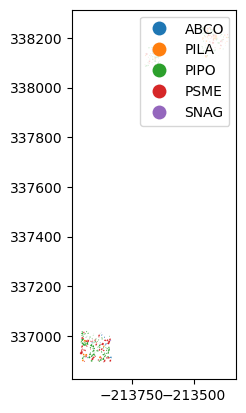

In [11]:
print(class_fractions)
print(IDs_in_original)
print(unique_class_names)
pred_IDs = np.argmax(class_fractions, axis=1)

pred_IDs = [int(unique_class_names[i]) for i in pred_IDs]
pred_class = [IDs_TO_LABELS[pred_ID] for pred_ID in pred_IDs]

# Load the data
gdf = gpd.read_file(LABELS_FILENAME)
site_gdf = gdf.iloc[IDs_in_original]
site_gdf["pred_class"] = pred_class
print("Ground truth")
site_gdf.plot(LABELS_COLUMN, legend=True, vmin=-0.5, vmax=9.5)
print("Predicted")
site_gdf.plot("pred_class", legend=True, vmin=-0.5, vmax=9.5)

GT classes ['PSME', 'PILA', 'PILA', 'PIPO', 'SNAG', 'PSME', 'PIPO', 'PIPO', 'PSME', 'PIPO', 'ABCO', 'PIPO', 'PSME', 'PILA', 'SNAG', 'PSME', 'PSME', 'PSME', 'PIPO', 'PSME', 'PIPO', 'PSME', 'ABCO', 'PIPO', 'PSME', 'PILA', 'PSME', 'PILA', 'ABCO', 'PIPO', 'ABCO', 'PILA', 'PILA', 'PILA', 'PSME', 'PSME', 'CADE', 'PILA', 'PSME', 'PILA', 'PSME', 'PILA', 'PILA', 'PIPO', 'PILA', 'ABCO', 'PSME', 'PSME', 'PIPO', 'ABCO', 'PSME', 'CADE', 'ABCO', 'ABCO', 'PSME', 'ABCO', 'PIPO', 'PILA', 'ABCO', 'PILA', 'PSME', 'PILA', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PILA', 'PSME', 'PIPO', 'PILA', 'PIPO', 'PILA', 'PIPO', 'PILA', 'ABCO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PILA', 'PIPO', 'PIPO', 'SNAG', 'PIPO', 'PIPO', 'SNAG', 'PIPO', 'CADE', 'PILA', 'PIPO', 'PSME', 'PIPO', 'PSME', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PSME', 'PIPO', 'SNAG', 'PIPO', 'PIPO', 'PSME', 'PIPO', 'SNAG', 'PIPO', 'PIPO', 'PSME', 'PIPO', 'SNAG', 'PIPO', 'CADE', 'PSME', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PSME', 'PSME', 'PIPO', 'CADE', 'PSME', 'PIPO', 'PSM

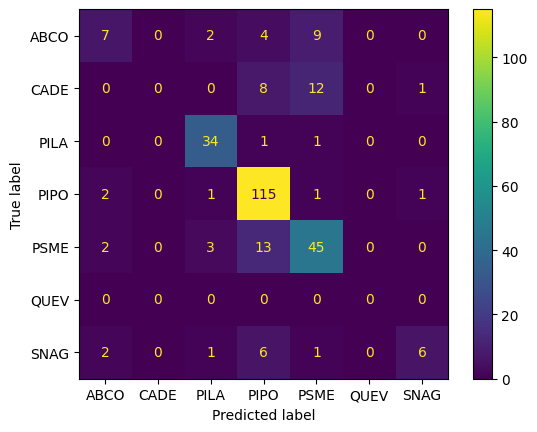

In [12]:
gt_list = site_gdf[LABELS_COLUMN].tolist()
pred_list = site_gdf["pred_class"].tolist()
print(f"GT classes {gt_list}")
print(f"Pred classes {pred_list}")

cf, classes, accuracy = compute_and_show_cf(
    pred_labels=pred_list,
    gt_labels=gt_list,
    labels=list(IDs_TO_LABELS.values()),
)
np.save(NUMPY_EXPORT_CONFUSION_MATRIX_FILE, cf)

# Ground truth classes

Loading transform to EPSG:4326


INFO:mesh_140629954322784:Loading transform to EPSG:4326


Loading mesh


INFO:mesh_140629954322784:Loading mesh


Reading the mesh


INFO:mesh_140629954322784:Reading the mesh


Selecting an ROI from mesh


INFO:mesh_140629954322784:Selecting an ROI from mesh


Standardizing ROI


INFO:mesh_140629954322784:Standardizing ROI


Dissolving ROI


INFO:mesh_140629954322784:Dissolving ROI


Setting CRS and buffering ROI


INFO:mesh_140629954322784:Setting CRS and buffering ROI


Dissolving buffered ROI


INFO:mesh_140629954322784:Dissolving buffered ROI


Extracting verts for dataframe


INFO:mesh_140629954322784:Extracting verts for dataframe


Checking intersection of verts with ROI


INFO:mesh_140629954322784:Checking intersection of verts with ROI


Extracting points from pyvista mesh


INFO:mesh_140629954322784:Extracting points from pyvista mesh


Extraction surface from subset mesh


INFO:mesh_140629954322784:Extraction surface from subset mesh


Extracting faces from mesh


INFO:mesh_140629954322784:Extracting faces from mesh


Loading texture


INFO:mesh_140629954322784:Loading texture


Could not read texture as a scalar from the pyvista mesh


Could not read texture as a numpy file


Sampling values from raster /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/delta/02_photogrammetry/exports/dtms/delta.tif: 100%|██████████| 806199/806199 [00:33<00:00, 23820.30it/s]


This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices


/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


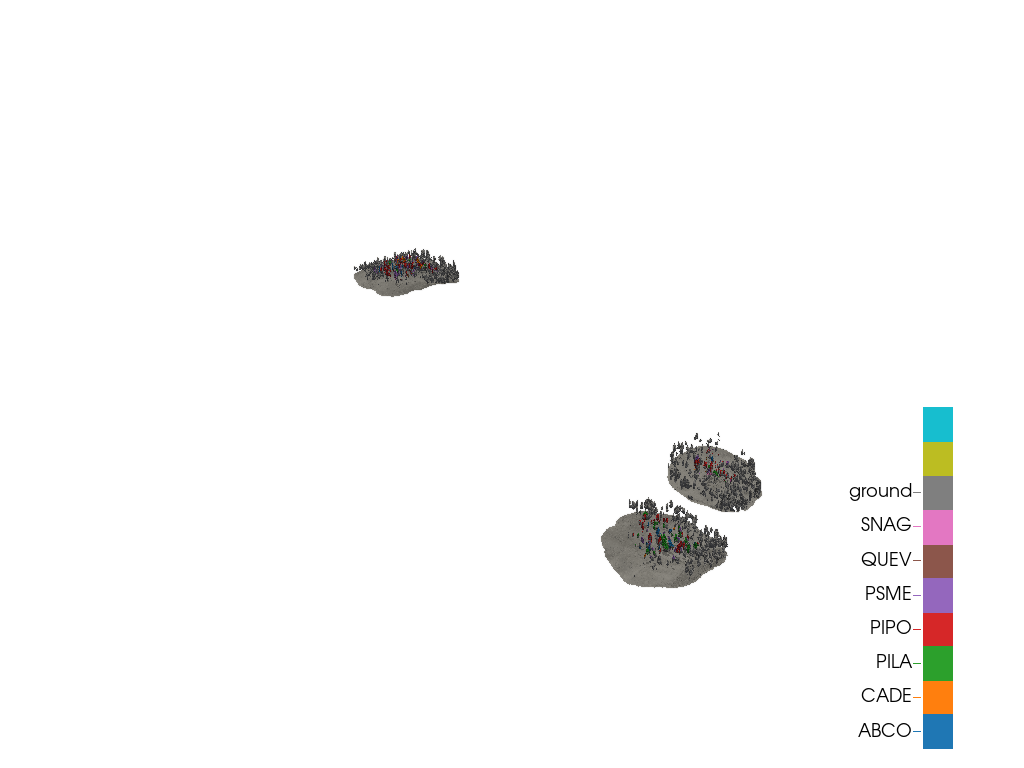

In [13]:
mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=CAMERAS_FILENAME,
    texture=LABELS_FILENAME,
    texture_column_name=LABELS_COLUMN,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
)
mesh.label_ground_class(
    height_above_ground_threshold=HEIGHT_ABOVE_GROUND_THRESH,
    DTM_file=DTM_FILE,
    set_mesh_texture=True,
)
mesh.vis(force_xvfb=True)

# Predicted classes

In [14]:
mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=CAMERAS_FILENAME,
    texture=NUMPY_EXPORT_FACES_TEXTURE_FILE,
    IDs_to_labels=IDs_TO_LABELS,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
)
mesh.vis(force_xvfb=True)

Loading transform to EPSG:4326


INFO:mesh_140629950860160:Loading transform to EPSG:4326


Loading mesh


INFO:mesh_140629950860160:Loading mesh


Reading the mesh


INFO:mesh_140629950860160:Reading the mesh


Selecting an ROI from mesh


INFO:mesh_140629950860160:Selecting an ROI from mesh


Standardizing ROI


INFO:mesh_140629950860160:Standardizing ROI


Dissolving ROI


INFO:mesh_140629950860160:Dissolving ROI


Setting CRS and buffering ROI


INFO:mesh_140629950860160:Setting CRS and buffering ROI


Dissolving buffered ROI


INFO:mesh_140629950860160:Dissolving buffered ROI


Extracting verts for dataframe


INFO:mesh_140629950860160:Extracting verts for dataframe


Checking intersection of verts with ROI


INFO:mesh_140629950860160:Checking intersection of verts with ROI


: 

# Colored mesh

Loading transform to EPSG:4326


INFO:mesh_140471142244512:Loading transform to EPSG:4326


Loading mesh


INFO:mesh_140471142244512:Loading mesh


Reading the mesh


INFO:mesh_140471142244512:Reading the mesh


Selecting an ROI from mesh


INFO:mesh_140471142244512:Selecting an ROI from mesh


Standardizing ROI


INFO:mesh_140471142244512:Standardizing ROI


Dissolving ROI


INFO:mesh_140471142244512:Dissolving ROI


Setting CRS and buffering ROI


INFO:mesh_140471142244512:Setting CRS and buffering ROI


Dissolving buffered ROI


INFO:mesh_140471142244512:Dissolving buffered ROI


Extracting verts for dataframe


INFO:mesh_140471142244512:Extracting verts for dataframe


Checking intersection of verts with ROI


INFO:mesh_140471142244512:Checking intersection of verts with ROI


Extracting points from pyvista mesh


INFO:mesh_140471142244512:Extracting points from pyvista mesh


Extraction surface from subset mesh


INFO:mesh_140471142244512:Extraction surface from subset mesh


Extracting faces from mesh


INFO:mesh_140471142244512:Extracting faces from mesh


Loading texture


INFO:mesh_140471142244512:Loading texture
/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


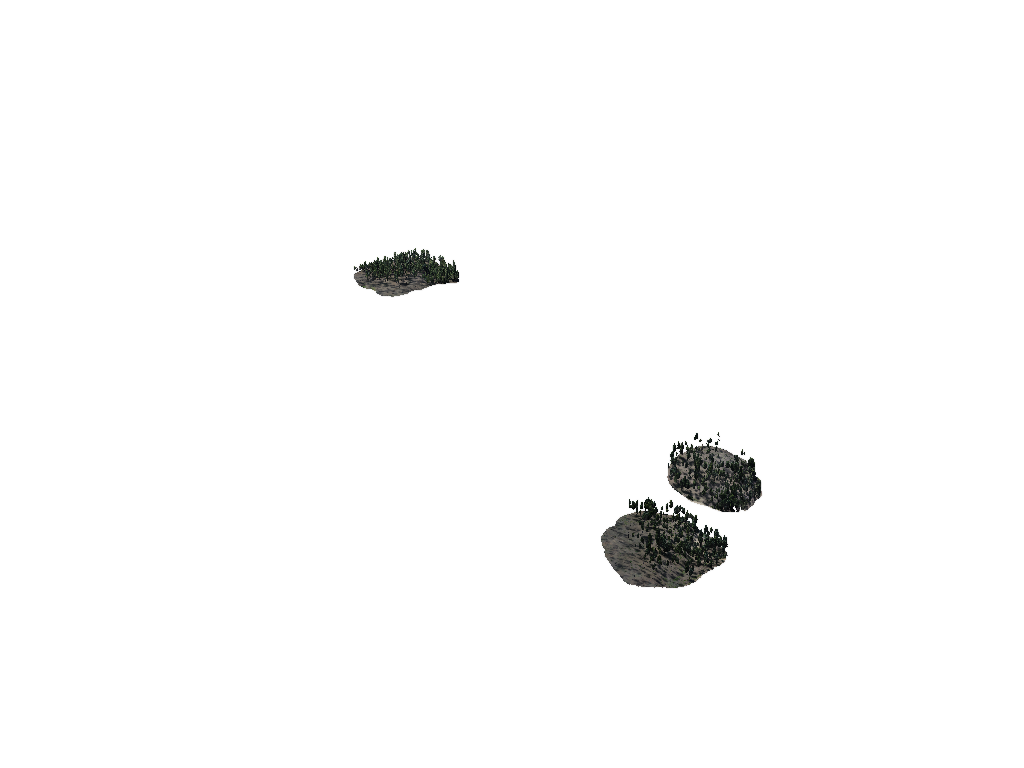

In [ ]:
mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=CAMERAS_FILENAME,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
)
mesh.vis(force_xvfb=True)